In [1]:
import torch
import pandas as pd
import dataprovider as dp
import process_edited as pce
import matplotlib.pyplot as plt
from dataprovider_pypots import ImpPypots

In [8]:
data = 'dataset/Metro_Traffic'
filename = f'{data}.csv'
real_df = pd.read_csv(filename)

#Metro_Traffic
real_df["holiday"] = real_df["holiday"].fillna(0)

#Pollution Data
#real_df["pm2.5"] = real_df["pm2.5"].fillna(0)

#bike_sharing.csv 
#cols = real_df.columns.to_list()
#cols[1] = "date" 
#real_df.columns = cols
#real_df = real_df.drop(columns=["instant", "yr", "mnth"])

# ImpPypots를 사용한 데이터셋 생성
data_dict = ImpPypots(real_df,
                 train_ratio=0.8,
                 val_ratio=0.1,
                 test_ratio=0.1,
                 seq_len=48,
                 stride=12,
                 rate=0.1,
                 pattern="point", # Different types of missing patterns : "point", "subseq", "block" 
                 sub_seq_len=12,
                 block_len=3,
                 block_width=2)


In [9]:
import VAE as vae
import DIFF as diff

VAE_training = 10000; diff_training = 20000; lat_dim = 6; 
real_df1 = real_df.drop(['date'], axis=1)

######################## Auto-encoder Training ########################
n_epochs = VAE_training; eps = 1e-5
weight_decay = 1e-6; lr = 2e-4; hidden_size = 512; num_layers = 2; batch_size = 40
channels = 64; min_beta = 1e-5; max_beta = 0.1; emb_dim = 128; time_dim = 8; threshold = 1; device = 'cuda'
ds = vae.train_autoencoder(real_df1, channels, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold, min_beta, max_beta, emb_dim, time_dim, lat_dim, device, data_dict)
latent_features = ds[1]

n_epochs = diff_training; hidden_dim = 512; num_layers = 2; diffusion_steps = 100; num_classes = len(latent_features)
diff = diff.train_diffusion(latent_features, real_df1, data_dict, hidden_dim, num_layers, diffusion_steps, n_epochs, num_classes)

Output()

Output()

In [10]:
import DIFF as Diff
from pypots.nn.functional import calc_mae

target_mask_test=data_dict['target_mask_test']
target_test=data_dict['response_test']
cond_test=data_dict['cond_test']
time_info_test=data_dict['time_info_test']
parser = data_dict['parser']

# Sampling process
device = 'cuda'
diffusion_steps = 100
Batch_size, Seq_len, _ = target_test.shape
Lat_dim = lat_dim
t_grid = torch.linspace(0, 1, Seq_len).view(1, -1, 1).to(device)
samples = Diff.sample(
    t_grid.repeat(Batch_size, 1, 1),
    Batch_size,
    Seq_len,
    Lat_dim,
    diffusion_steps,
    diff,
    time_info_test,
    cond_test,
    target_mask_test.float().to(device),
)

# Process the generated data
gen_output = ds[0].decoder(samples.to(device), target_mask_test, cond_test)
_synth_data = pce.convert_to_tensor(parser, gen_output, 1, Batch_size, Seq_len)

import torch.nn.functional as F

mae = calc_mae(_synth_data.to('cpu').numpy(), target_test.to('cpu').numpy(), target_mask_test.numpy())
mse = F.mse_loss(_synth_data.to('cpu'), target_test.to('cpu'), reduction='mean').numpy()

In [11]:
print(mae, mse)

0.047735110471921235 0.012712841


C:\Users\namjo\AppData\Local\Temp\ipykernel_40164\1497802081.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='upper left')


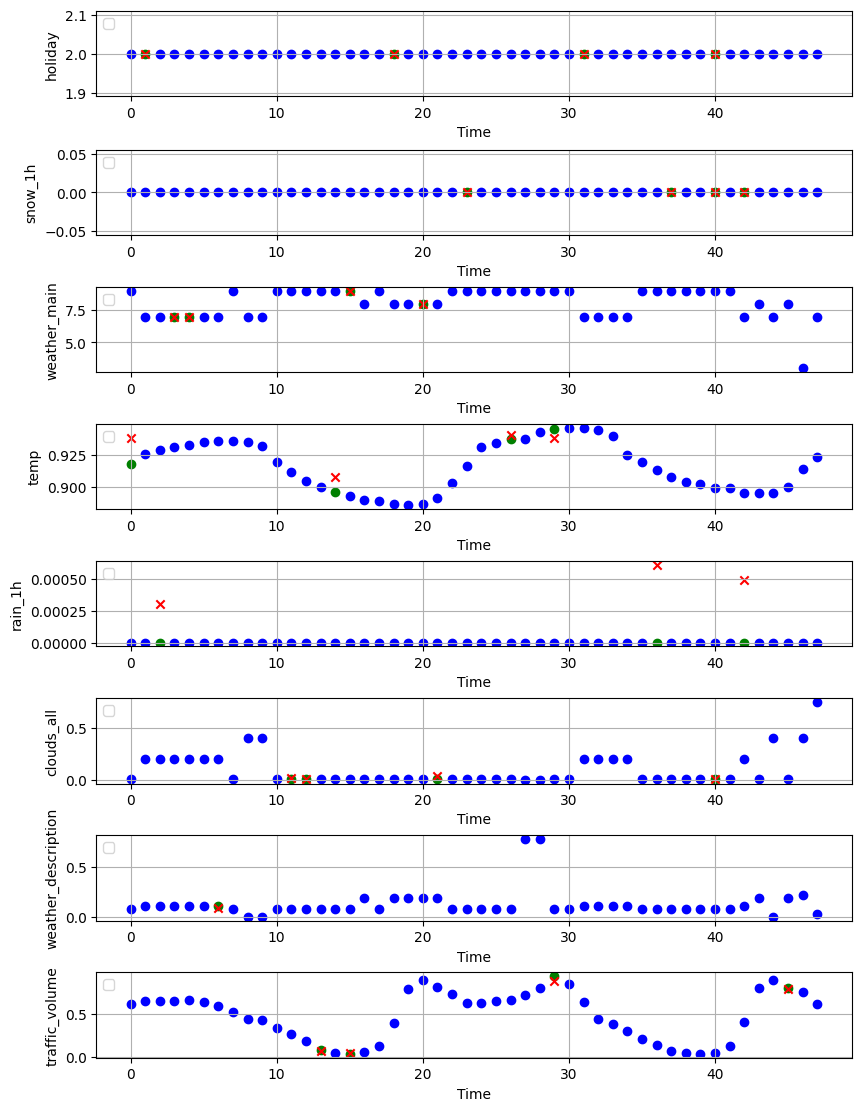

In [12]:
import matplotlib.pyplot as plt
import numpy as np

##################################################################################################################
label = 10
entire_data = target_test + cond_test

# Create a letter-sized figure
fig, axes = plt.subplots(entire_data.shape[2], 1, figsize=(8.5, 11), constrained_layout=True)  
parser = pce.DataFrameParser().fit(real_df1, threshold=1)
column_name = parser.column_name()

# Plot time series for each column
for i in range(entire_data.shape[2]):
    # Get data for plotting
    ground_truth = entire_data[label, :, i].numpy()  # Ensure it's a NumPy array
    ground_truth_missing = target_test[label, :, i].numpy()  # Ensure it's a NumPy array
    imputed_values = _synth_data[label, :, i].cpu().numpy()  # Ensure it's a NumPy array
    
    # Identify missing entries (1 indicates missing data)
    missing_entries = np.array(target_mask_test[label, :, i], dtype=bool)
    time_indices = np.arange(len(ground_truth))  # Generate integer indices
    
    # Plot the real data (Ground-truth Observed)
    axes[i].scatter(
        time_indices[~missing_entries],
        ground_truth[~missing_entries],
        color='b',
        marker='o',
        #label=f'Ground-truth observed-entries {column_name[i]}'
    )
    
    # Plot the missing entries (Ground-truth Missing)
    axes[i].scatter(
        time_indices[missing_entries],
        ground_truth[missing_entries],
        color='g',
        marker='o',
        #label=f'Ground-truth missing-entries {column_name[i]}'
    )
    
    # Plot the missing entries (Ground-truth Missing)
    axes[i].scatter(
        time_indices[missing_entries],
        imputed_values[missing_entries],
        color='r',
        marker='x',
        #label=f'Imputed-entries {column_name[i]}'
    )
    
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(f'{column_name[i]}')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

plt.show()